# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

38048


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')


Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero\figures.


## 1.2 setting up plotting parameters

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _font_size, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})  

In [6]:
# cell labels from RNA-MERFISH and celltype prediction
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]
# cell palette from RNA-MERFISH UMAP and stats
celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}


In [7]:
# this is the plotting order noted based on the snRNA transcriptional acitivty;
# we'd use this for all the graphs in this notebook
# use the snRNA data below (# section 3.1.1) if needs to re-calculate
sorted_cellplot_order = ['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 'Vip', 'Lamp5',
                  'L5/6 NP', 'Sst', 'Sncg', 'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L6b', 'L2/3 IT', 'L5 IT', 'L5 ET']

# 2. Load codebook

## Codebook

Example of [codebook_with_superenhancer_annotation](../0_locus_annotation/resources/merged_codebook_w_celltype_w_rank.csv)

In [8]:
# load codebook
# L drive is Crick Pu_SSD_0
postanalysis_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_20230201\MOp_WT_postanalysis\postanalysis_vCW2_sorted'

# Load sorted codebook (allows direct matrix slicing) with cell type info
import pandas as pd
codebook_df = pd.read_csv(r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_20230201\merged_codebook_w_celltype_w_rank.csv')

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

# keep relevant info and reset the format
import gene_to_loci as gl

codebook_df['loci_name']= codebook_df['name'].map(gl.loci_pos_format) 
codebook_df['loci_name']= codebook_df['loci_name'].map(lambda x: x[0])
codebook_df['chr_order']= codebook_df['chr_order'].map(lambda x: int(x))
codebook_df = codebook_df.set_index('loci_name')
codebook_df[['chr','chr_order','library','cell_type']]

,chr,chr_order,library,cell_type
loci_name,,,,
chr1_3742742_3759944,1,0,CTP11,['None']
chr1_6245958_6258969,1,1,CTP11,['None']
chr1_8740008_8759916,1,2,CTP11,['None']
chr1_9627926_9637875,1,3,CTP13,['L6_CT']
chr1_9799472_9811359,1,4,CTP13,['L2_3_IT']
...,...,...,...,...
chrX_166247682_166259932,X,60,CTP11,['None']
chrX_167157164_167167452,X,61,CTP13,['MicroPVM']
chrX_168746045_168757590,X,62,CTP11,['None']


## Refgen for gene dist matrix

Example of [refgen](../0_locus_annotation/resources/refgen_df_for_jie.csv)

In [9]:
codebook_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
df_refgen_savename = os.path.join(codebook_folder,'refgen_df_for_jie.csv')
df_refgen=pd.read_csv(df_refgen_savename,index_col=0)
df_refgen['chr'] = df_refgen['chr'].apply(lambda x: 'chr'+x)
df_refgen.head()

,name,id,chr,chr_order,library,dtype,loci_name,start,end,hyb,delta,region_id
0,1:3742742-3759944,1,chr1,0,CTP11,combo,chr1_3742742_3759944,3742742,3759944,0,0,1
1,1:6245958-6258969,2,chr1,1,CTP11,combo,chr1_6245958_6258969,6245958,6258969,1,2503216,2
2,1:8740008-8759916,3,chr1,2,CTP11,combo,chr1_8740008_8759916,8740008,8759916,2,4997266,3
3,1:9627926-9637875,1,chr1,3,CTP13,combo,chr1_9627926_9637875,9627926,9637875,3,5885184,4
4,1:9799472-9811359,2,chr1,4,CTP13,combo,chr1_9799472_9811359,9799472,9811359,4,6056730,5


In [10]:
chrom_number = []
for i, row in df_refgen.iterrows():
    if ('X' in row.chr):
        chrom_number.append(20)
    elif ('Y' in row.chr):
        chrom_number.append(21)
    else:
        chrom_number.append(int(row['chr'].split('chr')[-1]))
df_refgen['chrom_number'] = chrom_number
df_refgen.sort_values(['chrom_number','hyb'], inplace=True, ignore_index=True)
df_refgen.head()

,name,id,chr,chr_order,library,dtype,loci_name,start,end,hyb,delta,region_id,chrom_number
0,1:3742742-3759944,1,chr1,0,CTP11,combo,chr1_3742742_3759944,3742742,3759944,0,0,1,1
1,1:6245958-6258969,2,chr1,1,CTP11,combo,chr1_6245958_6258969,6245958,6258969,1,2503216,2,1
2,1:8740008-8759916,3,chr1,2,CTP11,combo,chr1_8740008_8759916,8740008,8759916,2,4997266,3,1
3,1:9627926-9637875,1,chr1,3,CTP13,combo,chr1_9627926_9637875,9627926,9637875,3,5885184,4,1
4,1:9799472-9811359,2,chr1,4,CTP13,combo,chr1_9799472_9811359,9799472,9811359,4,6056730,5,1


In [11]:
from scipy.spatial.distance import squareform, pdist
chr_gene_dist_matrices = {}
for chrom, df_chr in df_refgen.groupby('chr'):
    if 'Y' not in chrom:
        _df = df_chr.sort_values('hyb')
        _delta_values= np.zeros((len(_df),2))
        _delta_values[:,0] = _df.delta.values
        _gene_dist = squareform(pdist(_delta_values))
        chr_gene_dist_matrices[chrom] = _gene_dist

# 3. Load pre-summarized transcription density medians

Data can be generated from notebook

[7_summarize_ab_trans_density_all_loci_subclass](7_summarize_ab_trans_density_all_loci_subclass.ipynb)

In [12]:
# the calculated AB desnity ratio for single-cell
#compartment_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
AB_summary_fname = os.path.join(output_analysis_folder , r'Median_Summary_trans_AB_ratio_notNorm_r0.5_bysubclass_th_zero.csv')

AB_ratio_summary = pd.read_csv(AB_summary_fname, index_col=0).transpose()
AB_ratio_summary

,Oligo,OPC,Micro,Astro,Endo,L2/3 IT,L4/5 IT,L5 IT,L6 IT,L5 ET,L6 CT,L5/6 NP,L6b,Vip,Pvalb,Lamp5,Sst,Sncg
chr1_3742742_3759944,-0.422395,-0.336774,-0.278088,-0.489602,0.087817,-0.474198,-0.424039,-0.397661,-0.433375,-0.406431,-0.441964,-0.261607,-0.355470,-0.242751,-0.365409,-0.271475,-0.348622,-0.396724
chr1_6245958_6258969,-0.123587,-0.183419,-0.065169,-0.251864,0.346057,-0.384096,-0.395186,-0.374351,-0.342256,-0.363363,-0.392261,-0.175218,-0.197491,-0.301612,-0.214871,-0.229265,-0.127568,-0.257080
chr1_8740008_8759916,-0.384446,-0.052034,-0.286666,-0.411412,0.014480,-0.355418,-0.283315,-0.337409,-0.340426,-0.234319,-0.418353,-0.480288,-0.499484,0.005046,-0.199206,-0.062207,-0.122095,-0.540594
chr1_9627926_9637875,-0.229349,-0.036024,0.030728,-0.166186,0.244415,-0.300878,-0.238133,-0.336847,-0.161302,-0.240122,-0.237506,-0.296984,-0.294759,-0.280499,-0.201809,-0.023237,-0.200314,-0.325647
chr1_9799472_9811359,-0.079250,-0.062537,0.222733,-0.080703,0.478925,-0.249645,-0.248266,-0.203845,-0.208270,-0.187555,-0.207870,-0.272937,-0.285443,-0.315864,-0.393889,-0.104418,-0.167614,-0.507851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX_166247682_166259932,0.227213,0.121523,0.065605,0.364292,0.309217,-0.056365,-0.012575,-0.208386,-0.175914,-0.006859,-0.067705,0.058149,0.053279,-0.145523,-0.236549,-0.223829,-0.154113,-0.555910
chrX_167157164_167167452,0.102458,-0.135584,0.430749,0.054695,0.556941,-0.123888,-0.062526,-0.143780,-0.118719,-0.155330,-0.107538,0.072693,-0.160688,0.084008,-0.043039,-0.279229,-0.138286,-0.334614
chrX_168746045_168757590,-0.134512,-0.316071,-0.007819,-0.168453,0.254124,-0.243110,-0.215402,-0.186746,-0.175388,-0.235237,-0.294560,0.249351,-0.281637,-0.231542,-0.059648,-0.344906,-0.176298,-0.444930
chrX_169963295_170005197,-0.079956,0.124813,0.064583,0.029156,0.540016,-0.190289,-0.220554,-0.244034,-0.318961,-0.223761,-0.311680,-0.025918,-0.114135,-0.251041,-0.095843,-0.342024,-0.191063,-0.196725


## calculate regression factor between celltypes

In [13]:
### get Abratio normalization dict
from scipy import stats
from sklearn.linear_model import LinearRegression

# use common ref to regress which has more number of data
regress_each = False


ab_regression_coef_dict = {}

#ref_cls = 'Gluta'
# do regression for each class as ref_cls because the downstream marker gene analysis will be similar



if not regress_each:
    ref_cls = 'L2/3 IT'
    for _cls in AB_ratio_summary.columns:
        xs = np.array(AB_ratio_summary[ref_cls].tolist())
        ys = np.array(AB_ratio_summary[_cls].tolist())
        # correlation
        xs_good = xs[~(np.isnan(xs)&np.isnan(xs))]
        ys_good = ys[~(np.isnan(ys)&np.isnan(ys))]
        X=xs_good.reshape(-1, 1)
        y=ys_good.reshape(-1, 1)

        reg = LinearRegression(fit_intercept=True).fit(X, y)
        #reg = LinearRegression(fit_intercept=False).fit(X, y)

        #y_pred = reg.predict(X)
        ab_regression_coef_dict[_cls] = (reg.coef_[0], reg.intercept_)
    
else:
    for ref_cls in AB_ratio_summary.columns:
        ab_regression_coef_dict[ref_cls] = {}

        for _cls in AB_ratio_summary.columns:
            xs = np.array(AB_ratio_summary[ref_cls].tolist())
            ys = np.array(AB_ratio_summary[_cls].tolist())
            # correlation
            xs_good = xs[~(np.isnan(xs)&np.isnan(xs))]
            ys_good = ys[~(np.isnan(ys)&np.isnan(ys))]
            X=xs_good.reshape(-1, 1)
            y=ys_good.reshape(-1, 1)

            reg = LinearRegression(fit_intercept=True).fit(X, y)
            #reg = LinearRegression(fit_intercept=False).fit(X, y)

            #y_pred = reg.predict(X)
            ab_regression_coef_dict[ref_cls][_cls] = (reg.coef_[0], reg.intercept_)

ab_regression_coef_dict

{'Oligo': (array([0.84386026]), array([0.12749563])),
 'OPC': (array([0.7714856]), array([0.10379519])),
 'Micro': (array([0.71329066]), array([0.17957617])),
 'Astro': (array([0.77852525]), array([0.14804139])),
 'Endo': (array([0.47341445]), array([0.40170306])),
 'L2/3 IT': (array([1.]), array([-1.04083409e-17])),
 'L4/5 IT': (array([0.85274508]), array([-0.00076965])),
 'L5 IT': (array([0.75140804]), array([-0.0239076])),
 'L6 IT': (array([0.8351338]), array([-0.01002363])),
 'L5 ET': (array([0.60569472]), array([-0.02951882])),
 'L6 CT': (array([0.89414072]), array([-0.00783821])),
 'L5/6 NP': (array([0.56682118]), array([-0.03419425])),
 'L6b': (array([0.5758625]), array([-0.02862909])),
 'Vip': (array([0.43362486]), array([-0.05669304])),
 'Pvalb': (array([0.58494893]), array([-0.06387273])),
 'Lamp5': (array([0.49342148]), array([-0.04168428])),
 'Sst': (array([0.48583053]), array([-0.05148539])),
 'Sncg': (array([0.51772875]), array([-0.08075471]))}

# 4. Process all cellgroups for the markers

## Define shared parameters

In [14]:
# the cell groups to be analyzed
# the cell groups to be analyzed
sorted_group_order = ['L2/3 IT', 'L4/5 IT', 'L5 IT', 'L6 IT', 
                      'L5 ET','L5/6 NP', 'L6 CT', 'L6b',
                      'Pvalb','Sst','Vip','Lamp5', 'Sncg',
                      'Astro','Oligo','Micro']

## Load raw AB ratio if needs to re-calculate the median

Data can be generated from the notebook

[5_compute_ab_trans_density_singlecelll_subclass](5_compute_ab_trans_density_singlecelll_subclass.ipynb)

In [15]:
# the calculated AB desnity ratio for single-cell
#compartment_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
AB_ratio_fname = os.path.join(output_analysis_folder , r'trans_AB_ratio_notNorm_r0.5_bysubclass_th_zero.pkl')

import pickle
AB_ratio_by_group = pickle.load(open(AB_ratio_fname, 'rb'))

## Loop to process each cell group

### Note here we use median of single cell to represent each cell type (for each loci)

In [40]:
# re-import functions
import loci_1d_features as lf
import gene_selection as gs
import gene_to_loci as gl

re_calculate_AB = False
unique_SE = True
celltype_codebook_df = codebook_df.copy(deep=True)

In [54]:
# compile result as (marker loci of group) by (median of sc for group)
compiled_df = pd.DataFrame(columns = sorted_group_order)

for _marker_group in sorted_group_order[:]:
#for _marker_group in ['L5 ET','Micro']:    
    print (f'Process marker gene loci for {_marker_group}.')  
    ##############################################################################
    # 1. get specific SE-loci inds
    # modify group name consistency
    _marker_group_rename = _marker_group.replace('/','_').replace(' ','_')
    if _marker_group_rename == 'Micro':
        _marker_group_rename_SE = 'MicroPVM'
    elif _marker_group_rename == 'L5_ET':
        _marker_group_rename_SE = 'L5_PT'
    else:
        _marker_group_rename_SE = _marker_group_rename

    print(_marker_group_rename_SE)

    if unique_SE:
        im_loci_df = celltype_codebook_df[celltype_codebook_df['cell_type']==f"['{_marker_group_rename_SE}']"]
    else:
        im_loci_df = celltype_codebook_df[celltype_codebook_df['cell_type'].str.contains(_marker_group_rename_SE)]
    #sort loci
    im_loci_df  = lf.codebook_chr_order_for_loci_dataframe  (im_loci_df, codebook_df,sel_cols =['chr','chr_order','id'], 
                                               sort_df = True,
                                               sort_by_chr= True)
    
    # add expression change for
    im_loci_df['Expression_change']='upregulated'
    ##############################################################################
    # 2. add radom ctp13 genome loci as control
    non_up_loci_df = celltype_codebook_df[~celltype_codebook_df['cell_type'].str.contains(_marker_group_rename_SE)]
    non_up_loci_df = non_up_loci_df[~non_up_loci_df['cell_type'].str.contains('None')]
    # 2' if add radom ctp11 genome loci as control
    #non_up_loci_df = celltype_codebook_df[celltype_codebook_df['cell_type']=="['None']"]
    for _iter in range(0,100):
        random_loci = np.random.choice(non_up_loci_df.index,100, replace=False)
    random_loci_df = celltype_codebook_df.loc[random_loci]
    random_loci_df['Expression_change']='random_control'
    
    im_loci_df=pd.concat([im_loci_df,random_loci_df])
    #drop barcode cols
    keep_cols = [_c for _c in im_loci_df.columns if 'NDB' not in _c]
    keep_cols = [_c for _c in keep_cols if 'Stv' not in _c]
    im_loci_df=im_loci_df[keep_cols]
    
    # save markers info
    #_marker_savename = _marker_group.replace("/","_")
    #_groupby_savename = 'SE'
    #marker_genes_fname = os.path.join(output_analysis_folder,f'{_groupby_savename}_{_marker_savename}_vs_rest.csv')
    #im_loci_df.to_csv(marker_genes_fname)
    
    ##############################################################################

    ##############################################################################
    # 2. load AB ratio for relevant loci
    for _dir in ['upregulated','random_control'][:]:

        sel_im_loci_df = im_loci_df[im_loci_df['Expression_change']==_dir]
        # initate result df here so marker of each direction can be independently saved
        _marker_group_df = pd.DataFrame(columns = sorted_group_order)
        # get chr and chr_order
        sel_loci_key_list = lf.sorted_loci_keys_for_loci_dataframe(sel_im_loci_df)
        #original_inds = lf.find_chr_loci_iloc_from_loci_keys (codebook_df, sel_loci_key_list)

        # use chr and chr_order to retrieve AB ratio from single cell
        for loci_key in sel_loci_key_list:
            # append result for each loci from single cell
            # function to get the AB ratio for all cell group and append together
            if re_calculate_AB:
                _loci_group_df = loci_1d_features.sc_compartment_ratio_by_loci_key (AB_ratio_by_group, 
                                                                               sorted_group_order, 
                                                                                loci_key, 
                                                                                report_type = 'median',
                                                                                average_ratios_in_cell=True, 
                                                                                spot_num_th=600)
            else:
                _loci_name = codebook_df[(codebook_df['chr']==str(loci_key[0])) & (codebook_df['chr_order']==loci_key[1])].index[0]
                _loci_group_df = pd.DataFrame(AB_ratio_summary.loc[_loci_name]).transpose()
                _loci_group_df = _loci_group_df.reset_index(drop=True)

                
            if not regress_each:
                for _group in sorted_group_order:
                    m, b = ab_regression_coef_dict[_group][0],ab_regression_coef_dict[_group][1]
                    _loci_group_df.loc[0, _group] = (_loci_group_df.loc[0, _group]-b)/m 


            # concat loci
            _marker_group_df=pd.concat([_marker_group_df,_loci_group_df])


        # add loci, expression, group, gene info, etc
        _marker_group_df['loci_name'] = sel_im_loci_df.index.tolist()
        _marker_group_df['enhancer_name'] = sel_im_loci_df['enhancer_name'].tolist()
        _marker_group_df['Marker_group']=_marker_group
        _marker_group_df['Expression_change']=_dir

        # regression to normalize ABratio using the marker group as ref_cls
        if regress_each:
            for _group in sorted_group_order:
                m, b = ab_regression_coef_dict[_marker_group][_group][0],ab_regression_coef_dict[_marker_group][_group][1]
                _marker_group_df.loc[:, _group] = (_marker_group_df.loc[:, _group]-b)/m 
            # concat loci
            _marker_group_df=pd.concat([_marker_group_df,_loci_group_df])

        # concat for the marker cell group                  
        compiled_df=pd.concat([compiled_df,_marker_group_df])

    print('================================================================================')

# set loci_name as index 
compiled_df=compiled_df.set_index('loci_name')    

Process marker gene loci for L2/3 IT.
L2_3_IT
Process marker gene loci for L4/5 IT.
L4_5_IT
Process marker gene loci for L5 IT.
L5_IT
Process marker gene loci for L6 IT.
L6_IT
Process marker gene loci for L5 ET.
L5_PT
Process marker gene loci for L5/6 NP.
L5_6_NP
Process marker gene loci for L6 CT.
L6_CT
Process marker gene loci for L6b.
L6b
Process marker gene loci for Pvalb.
Pvalb
Process marker gene loci for Sst.
Sst
Process marker gene loci for Vip.
Vip
Process marker gene loci for Lamp5.
Lamp5
Process marker gene loci for Sncg.
Sncg
Process marker gene loci for Astro.
Astro
Process marker gene loci for Oligo.
Oligo
Process marker gene loci for Micro.
MicroPVM


In [55]:
compiled_df

,L2/3 IT,L4/5 IT,L5 IT,L6 IT,L5 ET,L5/6 NP,L6 CT,L6b,Pvalb,Sst,...,Lamp5,Sncg,Astro,Oligo,Micro,OPC,Endo,enhancer_name,Marker_group,Expression_change
loci_name,,,,,,,,,,,,,,,,,,,,,
chr1_9799472_9811359,-0.249645,-0.290235,-0.239467,-0.237382,-0.260917,-0.421196,-0.223713,-0.445964,-0.564180,-0.239032,...,-0.127140,-0.824942,-0.293818,-0.245000,0.060504,-0.062537,0.478925,1:9759317-9835402,L2/3 IT,upregulated
chr1_21522568_21534512,0.209331,0.204309,0.124253,0.201150,-0.151483,0.003572,-0.281341,-0.526654,-0.063538,-0.254606,...,0.167510,-0.061577,-0.530527,-0.465251,-0.593706,-0.295622,0.086054,1:21485446-21554433,L2/3 IT,upregulated
chr1_62926942_62936078,-0.078064,-0.144162,-0.064346,-0.097054,-0.116135,0.023720,-0.166660,-0.165785,-0.031432,-0.006665,...,0.162133,-0.120386,0.131904,0.059686,0.041360,0.096997,0.486718,1:62900963-62948089,L2/3 IT,upregulated
chr2_135670388_135680581,0.038647,0.113561,-0.084524,0.031504,-0.107108,0.268452,0.021585,0.002054,0.032323,-0.067597,...,0.231918,0.200275,0.090195,-0.077114,-0.126793,0.015601,0.808500,2:135658540-135684141,L2/3 IT,upregulated
chr3_157181787_157191783,-0.041559,-0.022571,-0.075201,-0.183741,-0.134721,-0.203436,-0.140075,0.141220,-0.219310,0.180617,...,-0.205856,-0.294181,-0.199487,-0.239993,-0.504183,0.056218,0.238026,3:157149588-157216143,L2/3 IT,upregulated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr13_88949850_88965434,-0.493751,-0.444274,-0.498174,-0.544973,-0.534722,-0.461427,-0.487375,-0.313365,-0.362685,-0.315861,...,-0.624552,-1.364439,-0.600204,-0.157068,-0.624697,-0.183944,0.041494,13:88899893-89015343,Micro,random_control
chr11_70033669_70044663,0.819831,0.944853,0.893350,0.891267,1.038386,1.000594,0.887860,1.091945,0.957767,1.154327,...,0.880774,1.795089,0.963613,0.948085,1.204537,0.796418,0.945014,11:70020422-70050516,Micro,random_control
chr5_33224445_33233607,0.566526,0.508867,0.428207,0.531130,0.586940,0.694120,0.511090,0.529774,0.481644,0.526827,...,0.296838,0.297142,0.665914,0.551533,0.604349,0.386583,0.639583,5:33203371-33246343,Micro,random_control


In [56]:
_groupby_savename = 'subclass'
compiled_df_savename = os.path.join(output_analysis_folder,f'{_groupby_savename}_SE_AB_ratio_regressed_heatmap_th_zero.csv')
compiled_df.to_csv(compiled_df_savename)
compiled_df

,L2/3 IT,L4/5 IT,L5 IT,L6 IT,L5 ET,L5/6 NP,L6 CT,L6b,Pvalb,Sst,...,Lamp5,Sncg,Astro,Oligo,Micro,OPC,Endo,enhancer_name,Marker_group,Expression_change
loci_name,,,,,,,,,,,,,,,,,,,,,
chr1_9799472_9811359,-0.249645,-0.290235,-0.239467,-0.237382,-0.260917,-0.421196,-0.223713,-0.445964,-0.564180,-0.239032,...,-0.127140,-0.824942,-0.293818,-0.245000,0.060504,-0.062537,0.478925,1:9759317-9835402,L2/3 IT,upregulated
chr1_21522568_21534512,0.209331,0.204309,0.124253,0.201150,-0.151483,0.003572,-0.281341,-0.526654,-0.063538,-0.254606,...,0.167510,-0.061577,-0.530527,-0.465251,-0.593706,-0.295622,0.086054,1:21485446-21554433,L2/3 IT,upregulated
chr1_62926942_62936078,-0.078064,-0.144162,-0.064346,-0.097054,-0.116135,0.023720,-0.166660,-0.165785,-0.031432,-0.006665,...,0.162133,-0.120386,0.131904,0.059686,0.041360,0.096997,0.486718,1:62900963-62948089,L2/3 IT,upregulated
chr2_135670388_135680581,0.038647,0.113561,-0.084524,0.031504,-0.107108,0.268452,0.021585,0.002054,0.032323,-0.067597,...,0.231918,0.200275,0.090195,-0.077114,-0.126793,0.015601,0.808500,2:135658540-135684141,L2/3 IT,upregulated
chr3_157181787_157191783,-0.041559,-0.022571,-0.075201,-0.183741,-0.134721,-0.203436,-0.140075,0.141220,-0.219310,0.180617,...,-0.205856,-0.294181,-0.199487,-0.239993,-0.504183,0.056218,0.238026,3:157149588-157216143,L2/3 IT,upregulated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr13_88949850_88965434,-0.493751,-0.444274,-0.498174,-0.544973,-0.534722,-0.461427,-0.487375,-0.313365,-0.362685,-0.315861,...,-0.624552,-1.364439,-0.600204,-0.157068,-0.624697,-0.183944,0.041494,13:88899893-89015343,Micro,random_control
chr11_70033669_70044663,0.819831,0.944853,0.893350,0.891267,1.038386,1.000594,0.887860,1.091945,0.957767,1.154327,...,0.880774,1.795089,0.963613,0.948085,1.204537,0.796418,0.945014,11:70020422-70050516,Micro,random_control
chr5_33224445_33233607,0.566526,0.508867,0.428207,0.531130,0.586940,0.694120,0.511090,0.529774,0.481644,0.526827,...,0.296838,0.297142,0.665914,0.551533,0.604349,0.386583,0.639583,5:33203371-33246343,Micro,random_control


# 5. Normalize the heatmap to relative foldchange

In [57]:
norm_compiled_df = pd.DataFrame(columns=sorted_group_order)

# simply loop to get the ref value (aka the value from the marker group)
ref_value_list = []
for _row_df in compiled_df.iloc():
    ref_group = _row_df['Marker_group']
    ref_value_list.append(_row_df[ref_group])

# norm the relevant columns-dervied matrix
mat = compiled_df[sorted_group_order].to_numpy()
ref_arr = np.array(ref_value_list)[:, np.newaxis]
norm_mat = mat-ref_arr

# add back relevant info
norm_compiled_df[sorted_group_order]=pd.DataFrame(norm_mat)
norm_compiled_df.index = compiled_df.index
for _col in ['enhancer_name','Marker_group','Expression_change']:
    norm_compiled_df[_col]=compiled_df[_col]

norm_compiled_df

,L2/3 IT,L4/5 IT,L5 IT,L6 IT,L5 ET,L5/6 NP,L6 CT,L6b,Pvalb,Sst,Vip,Lamp5,Sncg,Astro,Oligo,Micro,enhancer_name,Marker_group,Expression_change
loci_name,,,,,,,,,,,,,,,,,,,
chr1_9799472_9811359,0.000000,-0.040589,0.010178,0.012263,-0.011272,-0.171550,0.025932,-0.196319,-0.314535,0.010613,-0.348040,0.122506,-0.575297,-0.044172,0.004645,0.310149,1:9759317-9835402,L2/3 IT,upregulated
chr1_21522568_21534512,0.000000,-0.005022,-0.085078,-0.008181,-0.360814,-0.205759,-0.490672,-0.735985,-0.272869,-0.463937,-0.165172,-0.041821,-0.270908,-0.739858,-0.674582,-0.803037,1:21485446-21554433,L2/3 IT,upregulated
chr1_62926942_62936078,0.000000,-0.066098,0.013718,-0.018990,-0.038071,0.101784,-0.088596,-0.087721,0.046632,0.071399,-0.028664,0.240197,-0.042322,0.209968,0.137750,0.119424,1:62900963-62948089,L2/3 IT,upregulated
chr2_135670388_135680581,0.000000,0.074915,-0.123171,-0.007143,-0.145754,0.229805,-0.017061,-0.036592,-0.006324,-0.106243,0.327990,0.193271,0.161628,0.051548,-0.115761,-0.165440,2:135658540-135684141,L2/3 IT,upregulated
chr3_157181787_157191783,0.000000,0.018987,-0.033642,-0.142182,-0.093163,-0.161877,-0.098516,0.182778,-0.177751,0.222176,-0.207876,-0.164298,-0.252623,-0.157928,-0.198435,-0.462625,3:157149588-157216143,L2/3 IT,upregulated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr13_88949850_88965434,0.130946,0.180423,0.126523,0.079724,0.089975,0.163270,0.137321,0.311332,0.262011,0.308836,-0.097948,0.000145,-0.739743,0.024493,0.467629,0.000000,13:88899893-89015343,Micro,random_control
chr11_70033669_70044663,-0.384706,-0.259684,-0.311187,-0.313270,-0.166151,-0.203943,-0.316677,-0.112593,-0.246771,-0.050211,-0.190544,-0.323763,0.590552,-0.240924,-0.256452,0.000000,11:70020422-70050516,Micro,random_control
chr5_33224445_33233607,-0.037823,-0.095482,-0.176142,-0.073219,-0.017409,0.089772,-0.093258,-0.074575,-0.122705,-0.077522,-0.032639,-0.307511,-0.307207,0.061566,-0.052816,0.000000,5:33203371-33246343,Micro,random_control


In [22]:
_groupby_savename

'subclass'

In [58]:
norm_compiled_df_savename = os.path.join(output_analysis_folder,f'{_groupby_savename}_SE_AB_ratio_regressed_heatmap_norm_th_zero.csv')
norm_compiled_df.to_csv(norm_compiled_df_savename)

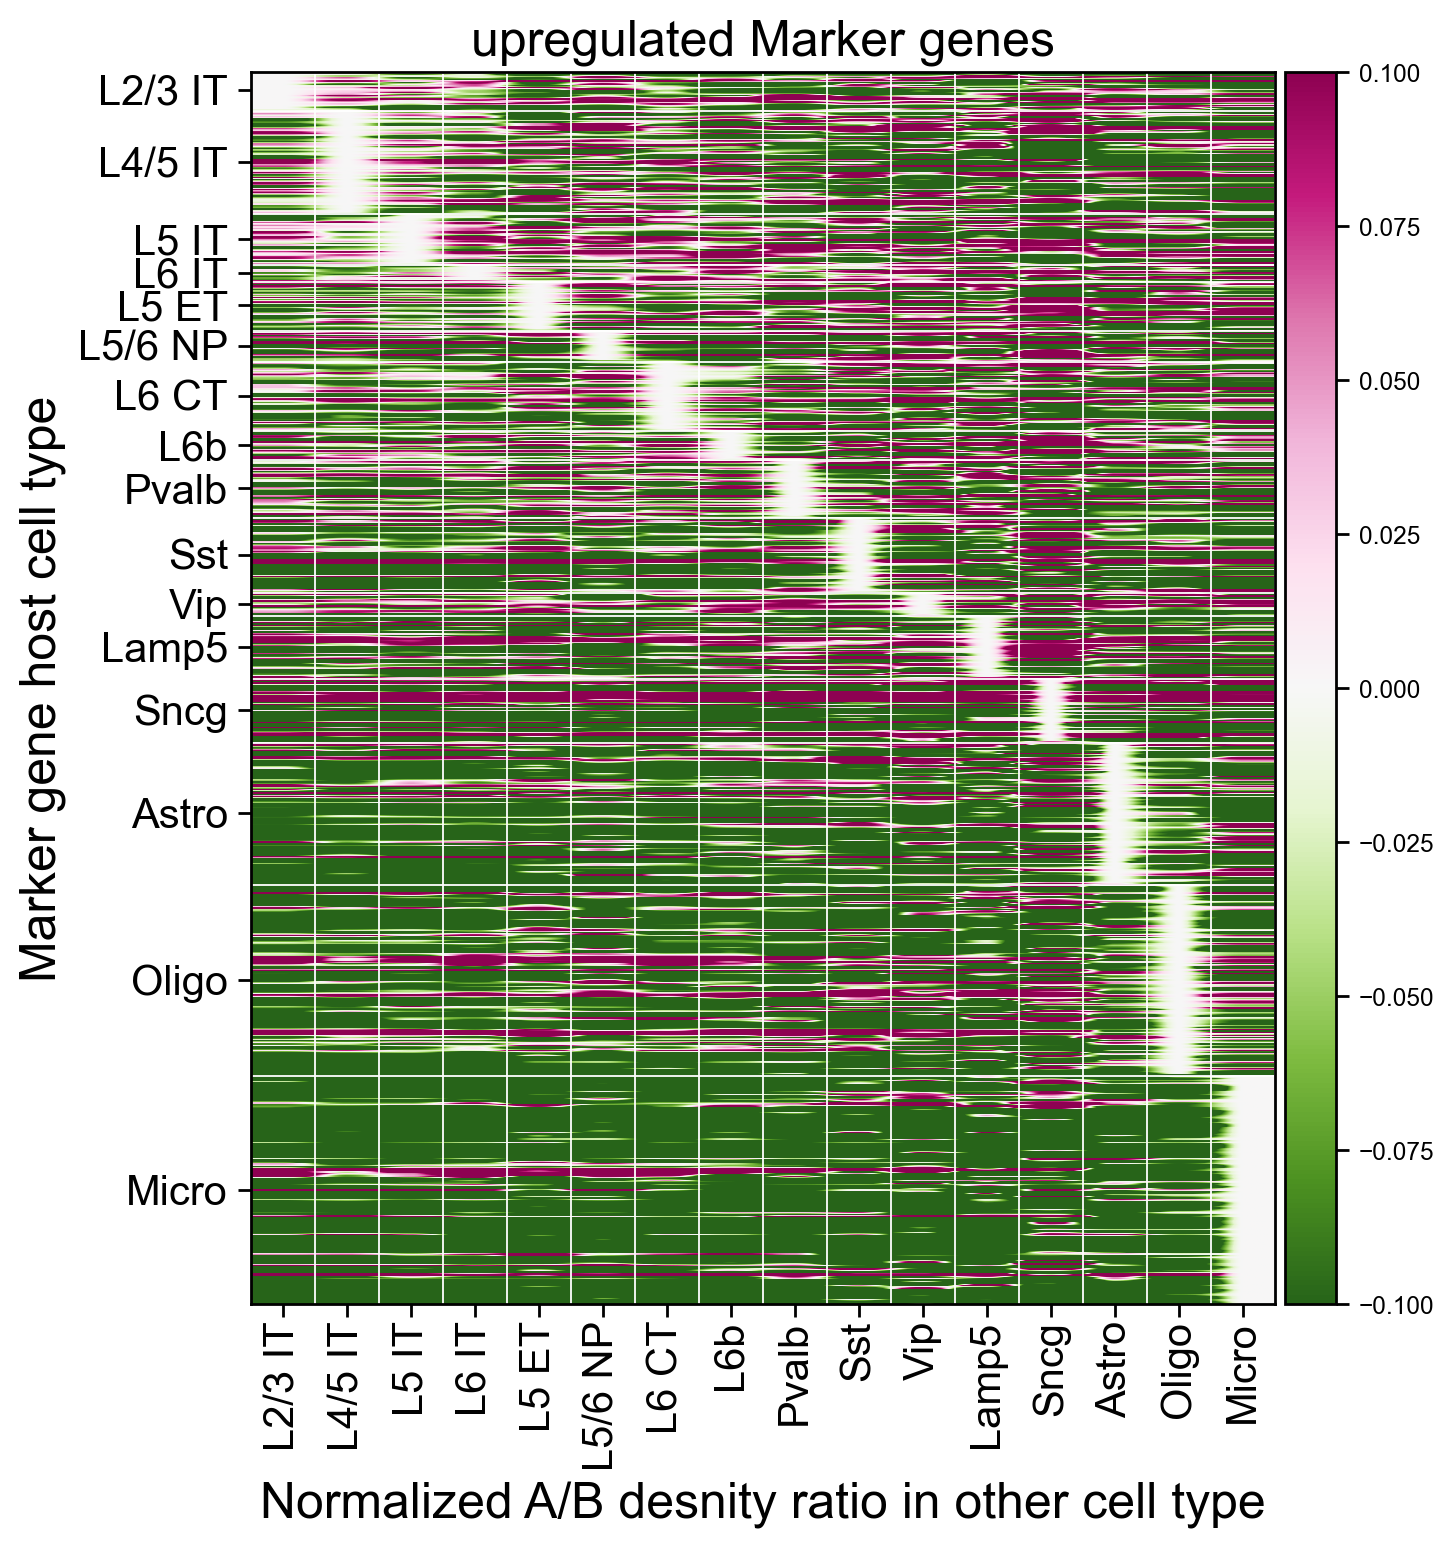

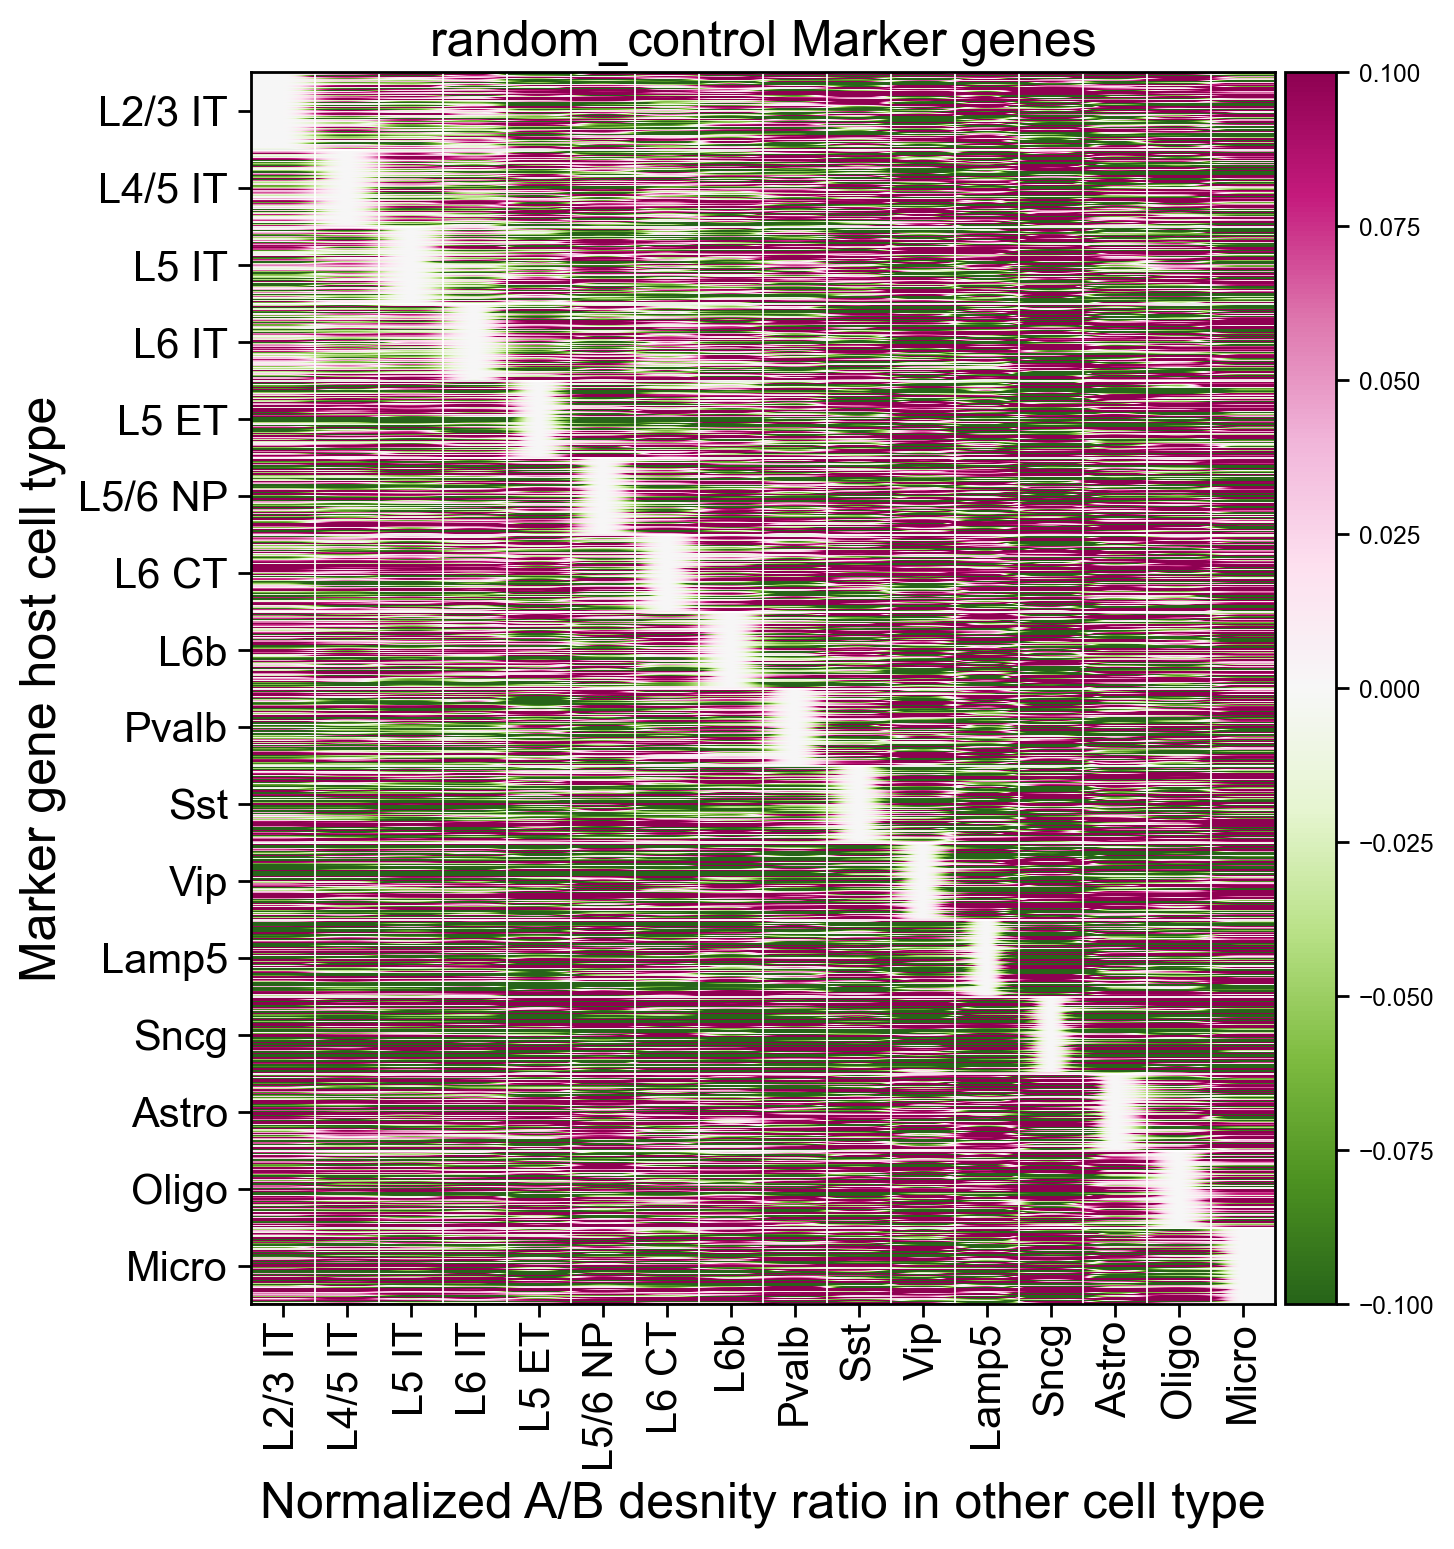

In [59]:
%matplotlib inline

#plt.style.use('dark_background')



for _dir in ['upregulated','random_control']:
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 8) , dpi=200, sharex=True, sharey=True)
    sub_compiled_df = norm_compiled_df[norm_compiled_df['Expression_change']==_dir]
    
    mat_df = sub_compiled_df[sorted_group_order]
    mat_plot = mat_df.to_numpy()

    _im = ax.imshow(mat_plot, vmin=-0.1, vmax=0.1, cmap='PiYG_r')
    #_im = ax.imshow(SE_ratio_mat, vmin=0.99, vmax=1.05, cmap='viridis')
    #vmin, vmax = 0.8, 1.25


    # xticks
    ax.set_xticks(ticks = np.arange(len(mat_df.columns)))
    ax.set_xticklabels(labels = mat_df.columns,fontsize=15,
               rotation=90)

    # y ticks
    group_plot = sub_compiled_df.groupby(['Marker_group'],sort=False).size().index
    group_nums = np.array(sub_compiled_df.groupby(['Marker_group'],sort=False).size().tolist())
    group_edges = np.cumsum(group_nums)
    yticks = (group_edges[1:] + group_edges[:-1])/2
    yticks = np.insert(yticks,0, int(group_nums[0]/2))
    yticks=[(_t-0.5) for _t in yticks]
    ax.set_yticks(ticks = yticks)
    ytick_labels  = [f'{_l}' for _l in group_plot]
    ax.set_yticklabels(labels = ytick_labels, fontsize=15,
               rotation=0)
    
    
    ax.tick_params('x', #labelsize=_font_size-1, 
                    #width=_ticklabel_width, length=_ticklabel_size,
                    labeltop=False,
                    pad=1, )

    # lines for separating
    ax.hlines(group_edges[:-1], -0.5, len(mat_df.columns)-0.5, color='white', linewidth=0.65)
    ax.vlines(np.arange(len(mat_df.columns))+0.5, -0.5, len(mat_df)-0.5, color='white', linewidth=0.65)

    #ax.xaxis.tick_top()
    ax.set_aspect('auto')

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(_im, cax=cax)
    
    ax.set_title(f'{_dir} Marker genes', fontsize=18)
    ax.set_xlabel('Normalized A/B desnity ratio in other cell type', fontsize=18)
    ax.set_ylabel('Marker gene host cell type', fontsize=18)

#plt.show()

## Reduce loci for each marker group to its median

In [27]:
len(mat_plot)

457

C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_38048\2646805520.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mat_df = sub_compiled_df.groupby(['Marker_group'],sort=False).median()[sorted_group_order]
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_38048\2646805520.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mat_df = sub_compiled_df.groupby(['Marker_group'],sort=False).median()[sorted_group_order]


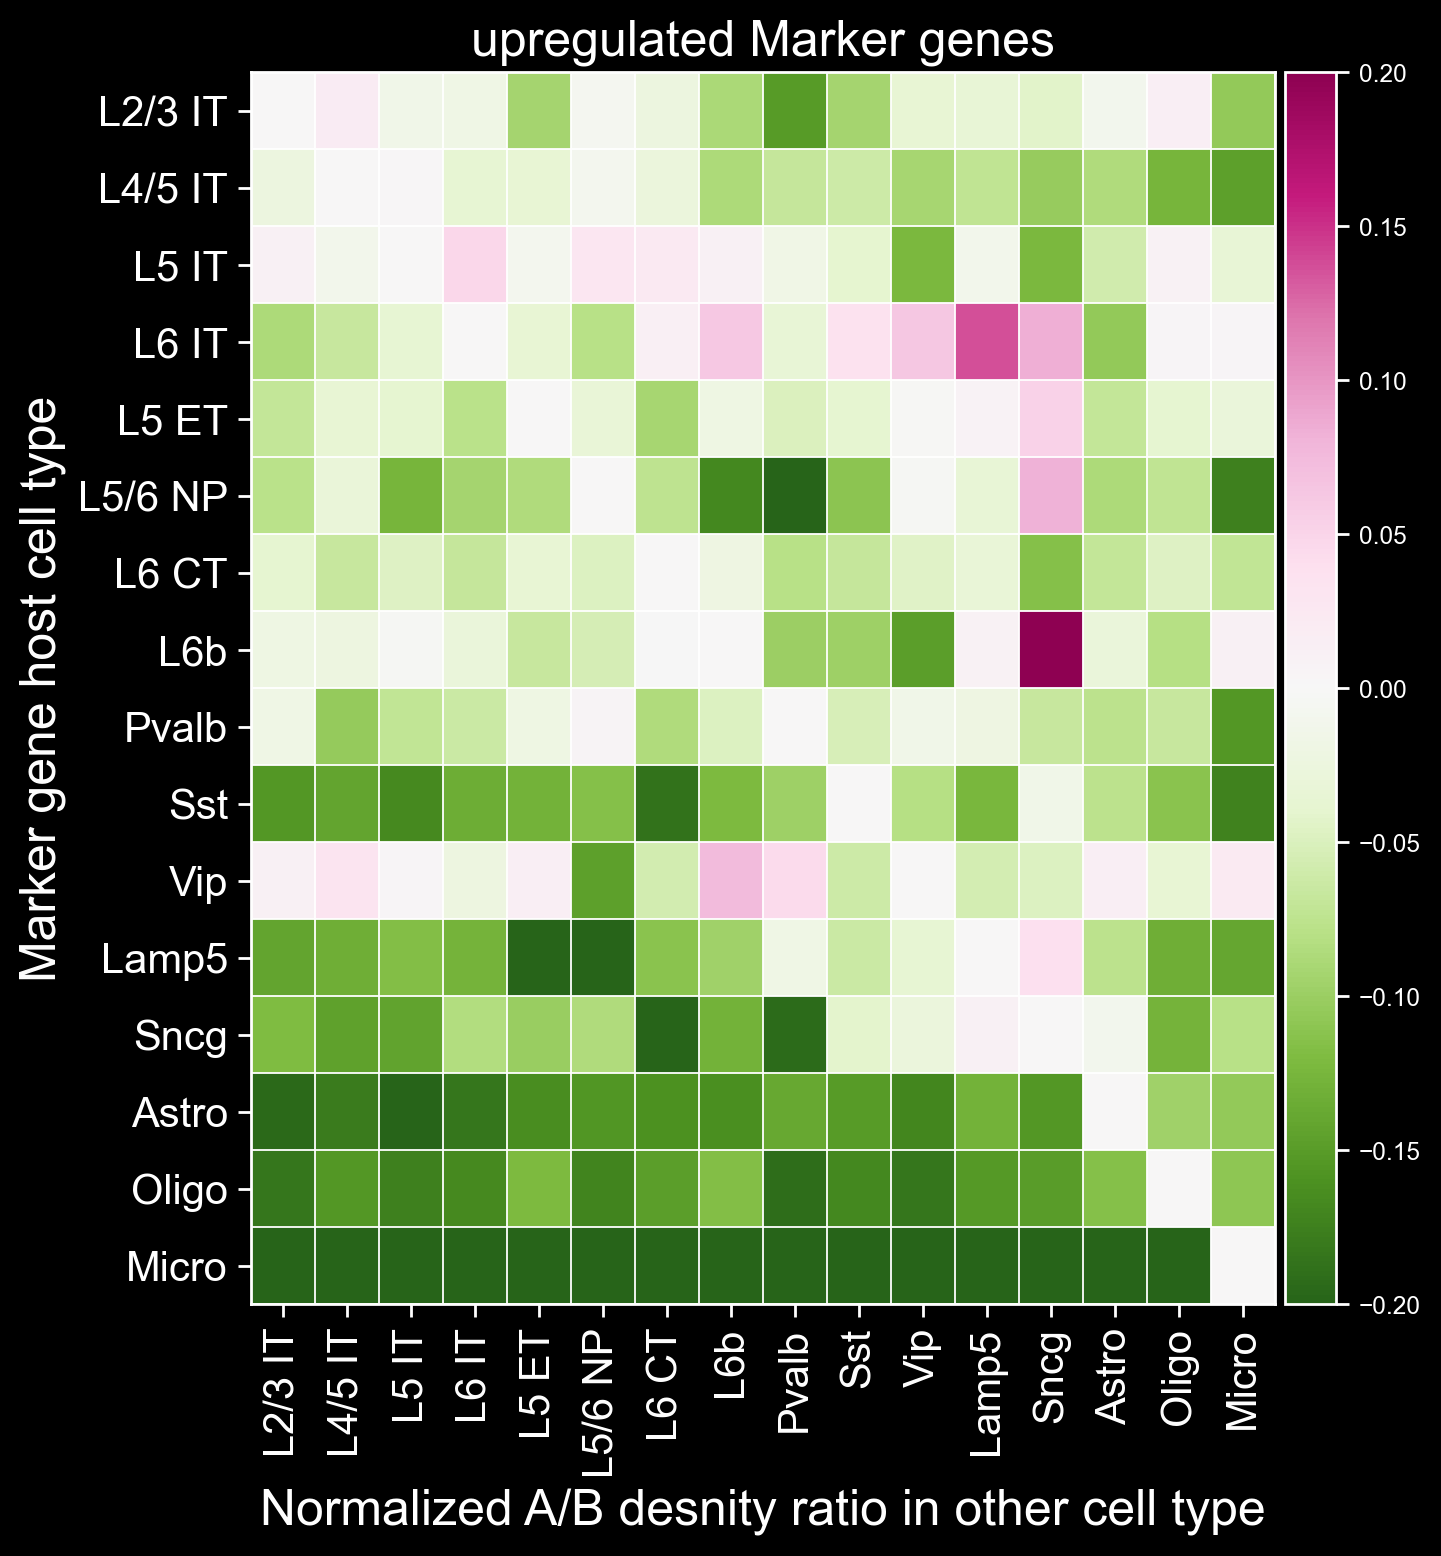

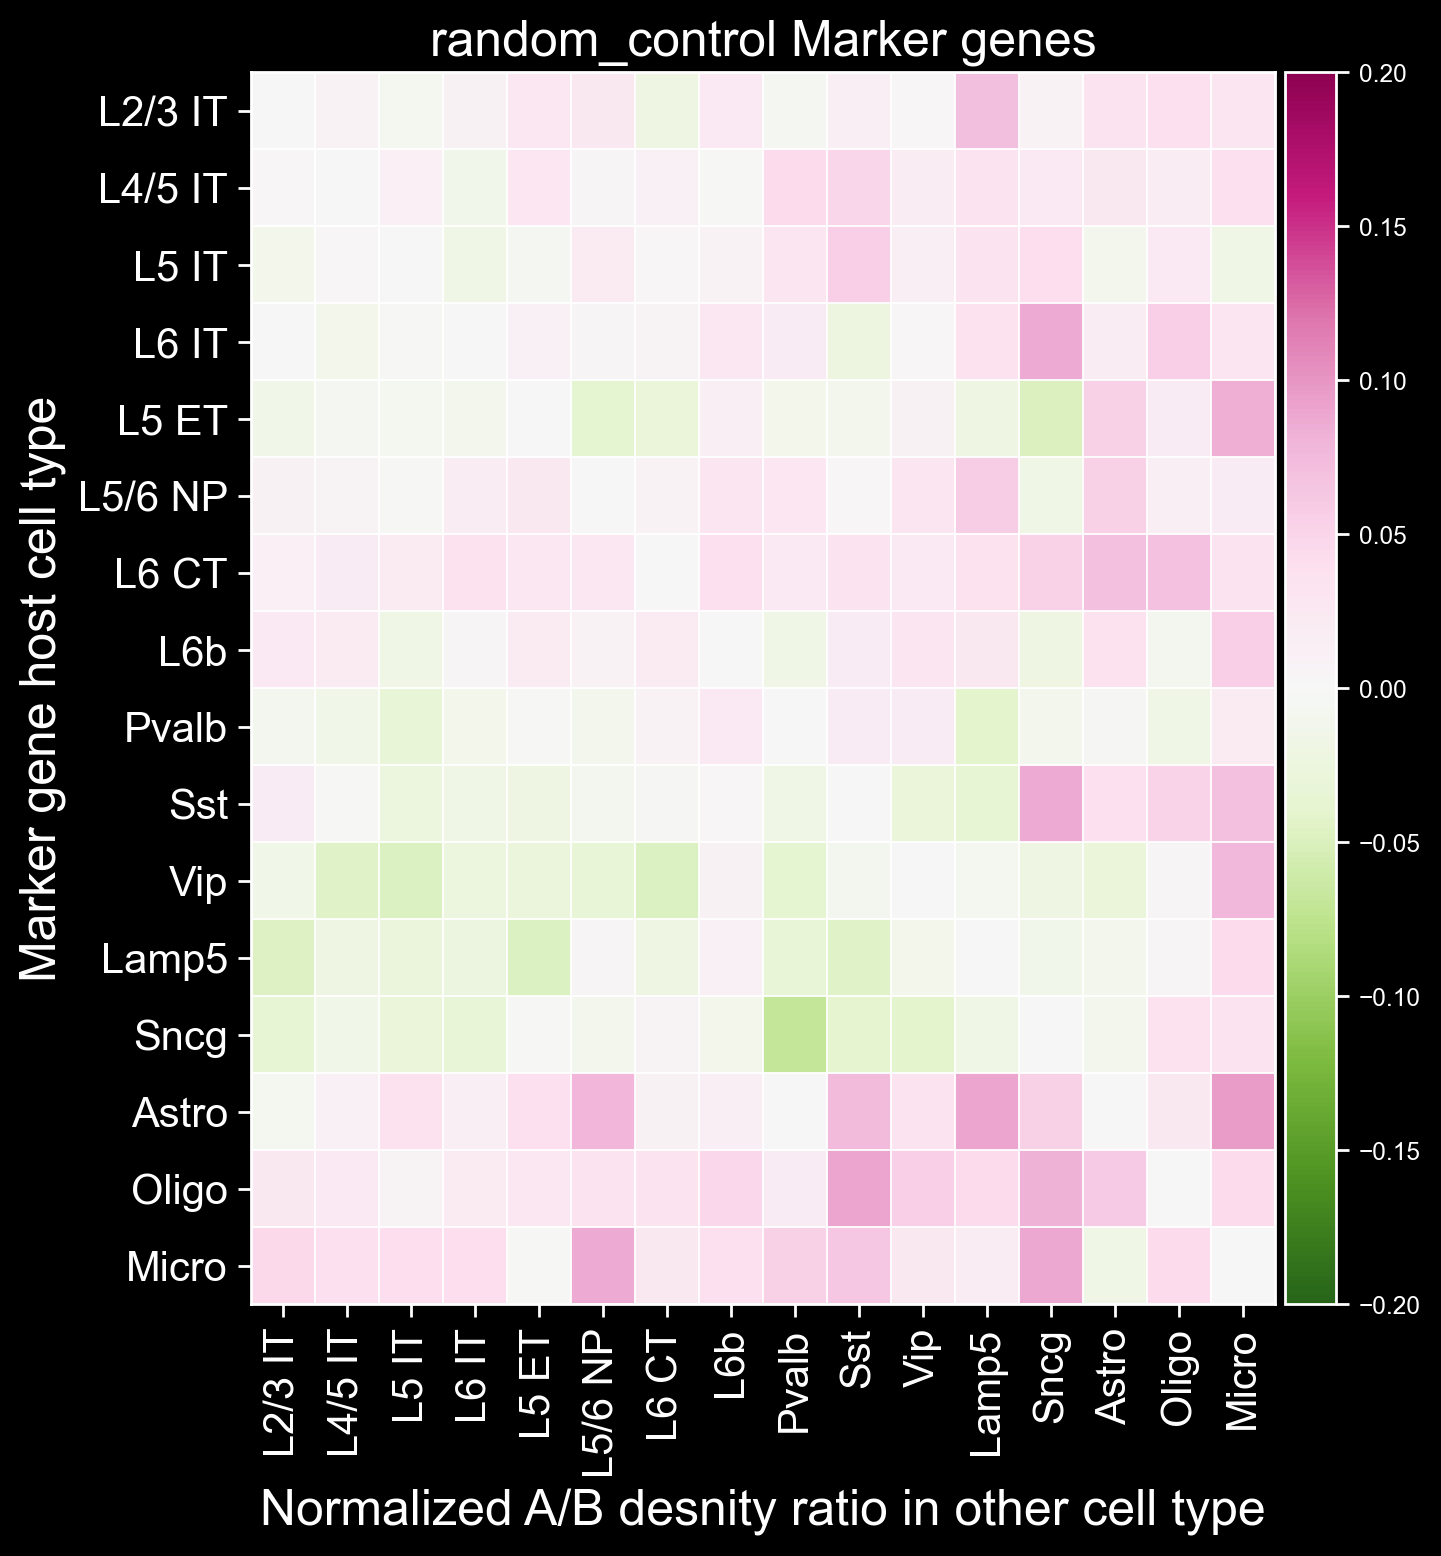

In [60]:
%matplotlib inline


plt.style.use('dark_background')



%matplotlib inline

#plt.style.use('dark_background')



for _dir in ['upregulated','random_control']:
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 8) , dpi=200, sharex=True, sharey=True)
    sub_compiled_df = norm_compiled_df[norm_compiled_df['Expression_change']==_dir]
    
    mat_df = sub_compiled_df.groupby(['Marker_group'],sort=False).median()[sorted_group_order]
    mat_plot = mat_df.to_numpy()

    _im = ax.imshow(mat_plot, vmin=-0.2, vmax=0.2, cmap='PiYG_r')
    #_im = ax.imshow(SE_ratio_mat, vmin=0.99, vmax=1.05, cmap='viridis')

    # xticks
    ax.set_xticks(ticks = np.arange(len(mat_df.columns)))
    ax.set_xticklabels(labels = mat_df.columns,fontsize=15,
               rotation=90)

    # y ticks
    group_plot = sub_compiled_df.groupby(['Marker_group'],sort=False).size().index
    ax.set_yticks(ticks = np.arange(len(group_plot)))
    ytick_labels  = group_plot
    ax.set_yticklabels(labels = ytick_labels,fontsize=15,
               rotation=0)

    # lines for separating
    ax.hlines(np.arange(len(mat_df.columns))+0.5, -0.5, len(mat_df.columns)-0.5, color='white', linewidth=0.65)
    ax.vlines(np.arange(len(mat_df.columns))+0.5, -0.5, len(mat_df)-0.5, color='white', linewidth=0.65)

    #ax.xaxis.tick_top()
    ax.set_aspect('auto')

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(_im, cax=cax)
    
    ax.set_title(f'{_dir} Marker genes', fontsize=18)
    ax.set_xlabel('Normalized A/B desnity ratio in other cell type', fontsize=18)
    ax.set_ylabel('Marker gene host cell type', fontsize=18)
    ax.set_ylabel('Marker gene host cell type', fontsize=18)

